##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# tf.data: Build TensorFlow input pipelines

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

The `tf.data` API enables you to build complex input pipelines from simple,
reusable pieces. For example, the pipeline for an image model might aggregate
data from files in a distributed file system, apply random perturbations to each
image, and merge randomly selected images into a batch for training. The
pipeline for a text model might involve extracting symbols from raw text data,
converting them to embedding identifiers with a lookup table, and batching
together sequences of different lengths. The `tf.data` API makes it possible to
handle large amounts of data, read from different data formats, and perform
complex transformations.

The `tf.data` API introduces a `tf.data.Dataset` abstraction that represents a
sequence of elements, in which each element consists of one or more components.
For example, in an image pipeline, an element might be a single training
example, with a pair of tensor components representing the image and its label.

There are two distinct ways to create a dataset:

*   A data **source** constructs a `Dataset` from data stored in memory or in
    one or more files.

*   A data **transformation** constructs a dataset from one or more
    `tf.data.Dataset` objects.


In [2]:
import tensorflow as tf

print(tf.__version__)

2.15.0


In [3]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## Basic mechanics
<a id="basic-mechanics"/>

To create an input pipeline, you must start with a data *source*. For example,
to construct a `Dataset` from data in memory, you can use
`tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.
Alternatively, if your input data is stored in a file in the recommended
TFRecord format, you can use `tf.data.TFRecordDataset()`.

Once you have a `Dataset` object, you can *transform* it into a new `Dataset` by
chaining method calls on the `tf.data.Dataset` object. For example, you can
apply per-element transformations such as `Dataset.map`, and multi-element
transformations such as `Dataset.batch`. Refer to the documentation for
`tf.data.Dataset` for a complete list of transformations.

The `Dataset` object is a Python iterable. This makes it possible to consume its
elements using a for loop:

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [5]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


Or by explicitly creating a Python iterator using `iter` and consuming its
elements using `next`:

In [6]:
it = iter(dataset)

print(next(it).numpy())

8


Alternatively, dataset elements can be consumed using the `reduce`
transformation, which reduces all elements to produce a single result. The
following example illustrates how to use the `reduce` transformation to compute
the sum of a dataset of integers.

In [7]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


<!-- TODO(jsimsa): Talk about `tf.function` support. -->

<a id="dataset_structure"></a>
### Dataset structure

A dataset produces a sequence of *elements*, where each element is
the same (nested) structure of *components*. Individual components
of the structure can be of any type representable by
`tf.TypeSpec`, including `tf.Tensor`, `tf.sparse.SparseTensor`,
`tf.RaggedTensor`, `tf.TensorArray`, or `tf.data.Dataset`.

The Python constructs that can be used to express the (nested)
structure of elements include `tuple`, `dict`, `NamedTuple`, and
`OrderedDict`. In particular, `list` is not a valid construct for
expressing the structure of dataset elements. This is because
early `tf.data` users felt strongly about `list` inputs (for example, when passed
to `tf.data.Dataset.from_tensors`) being automatically packed as
tensors and `list` outputs (for example, return values of user-defined
functions) being coerced into a `tuple`. As a consequence, if you
would like a `list` input to be treated as a structure, you need
to convert it into `tuple` and if you would like a `list` output
to be a single component, then you need to explicitly pack it
using `tf.stack`.

The `Dataset.element_spec` property allows you to inspect the type
of each element component. The property returns a *nested structure*
of `tf.TypeSpec` objects, matching the structure of the element,
which may be a single component, a tuple of components, or a nested
tuple of components. For example:

In [8]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [9]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [10]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [11]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [12]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

The `Dataset` transformations support datasets of any structure. When using the
`Dataset.map`, and `Dataset.filter` transformations,
which apply a function to each element, the element structure determines the
arguments of the function:

In [13]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1

<_TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.int32, name=None)>

In [14]:
for z in dataset1:
  print(z.numpy())

[2 6 9 8 8 4 4 6 9 1]
[3 6 6 6 3 9 6 8 8 7]
[3 8 5 7 6 3 7 2 5 8]
[7 4 1 6 2 1 1 5 7 9]


In [15]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))>

In [16]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<_ZipDataset element_spec=(TensorSpec(shape=(10,), dtype=tf.int32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None)))>

In [17]:
for a, (b,c) in dataset3:
  print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


## Reading input data


### Consuming NumPy arrays

Refer to the [Loading NumPy arrays](../tutorials/load_data/numpy.ipynb) tutorial for more examples.

If all of your input data fits in memory, the simplest way to create a `Dataset`
from them is to convert them to `tf.Tensor` objects and use
`Dataset.from_tensor_slices`.

In [18]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [19]:
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

Note: The above code snippet will embed the `features` and `labels` arrays
in your TensorFlow graph as `tf.constant()` operations. This works well for a
small dataset, but wastes memory---because the contents of the array will be
copied multiple times---and can run into the 2GB limit for the `tf.GraphDef`
protocol buffer.

### Consuming Python generators

Another common data source that can easily be ingested as a `tf.data.Dataset` is the python generator.

Caution: While this is a convenient approach it has limited portability and scalability. It must run in the same python process that created the generator, and is still subject to the Python [GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock).

In [20]:
def count(stop):
  i = 0
  while i<stop:
    yield i
    i += 1

In [21]:
for n in count(5):
  print(n)

0
1
2
3
4


The `Dataset.from_generator` constructor converts the python generator to a fully functional `tf.data.Dataset`.

The constructor takes a callable as input, not an iterator. This allows it to restart the generator when it reaches the end. It takes an optional `args` argument, which is passed as the callable's arguments.

The `output_types` argument is required because `tf.data` builds a `tf.Graph` internally, and graph edges require a `tf.dtype`.

In [22]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

In [23]:
for count_batch in ds_counter.repeat().batch(10).take(10):
  print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


The `output_shapes` argument is not *required* but is highly recommended as many TensorFlow operations do not support tensors with an unknown rank. If the length of a particular axis is unknown or variable, set it as `None` in the `output_shapes`.

It's also important to note that the `output_shapes` and `output_types` follow the same nesting rules as other dataset methods.

Here is an example generator that demonstrates both aspects: it returns tuples of arrays, where the second array is a vector with unknown length.

In [24]:
def gen_series():
  i = 0
  while True:
    size = np.random.randint(0, 10)
    yield i, np.random.normal(size=(size,))
    i += 1

In [25]:
for i, series in gen_series():
  print(i, ":", str(series))
  if i > 5:
    break

0 : [-0.5812]
1 : [ 0.4224  2.4148  0.0092  0.0367 -1.5778  0.1484  0.7278 -0.6647]
2 : [-1.2564  0.093   0.0881  0.4004 -0.7535 -0.8214  1.3435 -0.5043 -0.0224]
3 : [ 0.3813  1.369   1.2009 -0.1389  1.7484  1.109  -1.827  -1.5282 -1.0303]
4 : [-0.8841  1.328  -0.1833 -0.0434 -1.5361]
5 : [-0.8664  0.825  -0.8401 -0.431   0.7735  0.0207]
6 : [-1.5967  1.8088 -0.0494]


The first output is an `int32` the second is a `float32`.

The first item is a scalar, shape `()`, and the second is a vector of unknown length, shape `(None,)`

In [26]:
ds_series = tf.data.Dataset.from_generator(
    gen_series,
    output_types=(tf.int32, tf.float32),
    output_shapes=((), (None,)))

ds_series

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

Now it can be used like a regular `tf.data.Dataset`. Note that when batching a dataset with a variable shape, you need to use `Dataset.padded_batch`.

In [27]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10)

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())

[10  6 14  3  0 16 23  4 21  8]

[[ 0.6367  0.4596  0.8639  0.3632  0.      0.      0.      0.      0.    ]
 [ 1.8107 -0.164  -0.2113  1.2877  0.2113 -0.4887  0.2202 -0.8295  0.    ]
 [-0.3542  0.3642  1.0453 -1.2095 -0.5212 -0.2431  0.7766  1.1505  1.1803]
 [-1.553  -1.5167  1.2224  0.7464  0.7024 -0.2151 -2.7562  0.      0.    ]
 [-0.6535 -0.351  -1.2317  0.5109 -0.7752 -0.9223 -1.8293  0.4411  0.    ]
 [ 1.7525  1.1058  0.4231 -0.1459  0.4206  0.3682 -1.1636 -0.5658 -0.4225]
 [ 0.4536 -1.4486  0.1223 -1.7697  1.1218 -0.6865  1.4164  0.2692  0.    ]
 [ 0.9091  0.7638  2.1541 -0.2949 -1.2223 -0.0401 -1.5987 -0.7545 -0.2129]
 [-0.1167  0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-1.9759  0.      0.      0.      0.      0.      0.      0.      0.    ]]


For a more realistic example, try wrapping `preprocessing.image.ImageDataGenerator` as a `tf.data.Dataset`.

First download the data:

In [28]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 2s 0us/step


Create the `image.ImageDataGenerator`

In [29]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [30]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [31]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [32]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers),
    output_types=(tf.float32, tf.float32),
    output_shapes=([32,256,256,3], [32,5])
)

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [33]:
for images, labels in ds.take(1):
  print('images.shape: ', images.shape)
  print('labels.shape: ', labels.shape)


Found 3670 images belonging to 5 classes.
images.shape:  (32, 256, 256, 3)
labels.shape:  (32, 5)


### Consuming TFRecord data

Refer to the [Loading TFRecords](../tutorials/load_data/tfrecord.ipynb) tutorial for an end-to-end example.

The `tf.data` API supports a variety of file formats so that you can process
large datasets that do not fit in memory. For example, the TFRecord file format
is a simple record-oriented binary format that many TensorFlow applications use
for training data. The `tf.data.TFRecordDataset` class enables you to
stream over the contents of one or more TFRecord files as part of an input
pipeline.

Here is an example using the test file from the French Street Name Signs (FSNS).

In [34]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

7904079/7904079 [==============================] - 0s 0us/step


The `filenames` argument to the `TFRecordDataset` initializer can either be a
string, a list of strings, or a `tf.Tensor` of strings. Therefore if you have
two sets of files for training and validation purposes, you can create a factory
method that produces the dataset, taking filenames as an input argument:


In [35]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

Many TensorFlow projects use serialized `tf.train.Example` records in their TFRecord files. These need to be decoded before they can be inspected:

In [36]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

### Consuming text data

Refer to the [Load text](../tutorials/load_data/text.ipynb) tutorial for an end-to-end example.

Many datasets are distributed as one or more text files. The
`tf.data.TextLineDataset` provides an easy way to extract lines from one or more
text files. Given one or more filenames, a `TextLineDataset` will produce one
string-valued element per line of those files.

In [37]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

807992/807992 [==============================] - 0s 0us/step


In [38]:
dataset = tf.data.TextLineDataset(file_paths)

Here are the first few lines of the first file:

In [39]:
for line in dataset.take(5):
  print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


To alternate lines between files use `Dataset.interleave`. This makes it easier to shuffle files together. Here are the first, second and third lines from each translation:

In [40]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
  if i % 3 == 0:
    print()
  print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


By default, a `TextLineDataset` yields *every* line of each file, which may
not be desirable, for example, if the file starts with a header line, or contains comments. These lines can be removed using the `Dataset.skip()` or
`Dataset.filter` transformations. Here, you skip the first line, then filter to
find only survivors.

In [41]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

30874/30874 [==============================] - 0s 0us/step


In [42]:
for line in titanic_lines.take(10):
  print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [43]:
def survived(line):
  return tf.not_equal(tf.strings.substr(line, 0, 1), "0")

survivors = titanic_lines.skip(1).filter(survived)

In [44]:
for line in survivors.take(10):
  print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


### Consuming CSV data

Refer to the [Loading CSV Files](../tutorials/load_data/csv.ipynb) and [Loading Pandas DataFrames](../tutorials/load_data/pandas_dataframe.ipynb) tutorials for more examples.

The CSV file format is a popular format for storing tabular data in plain text.

For example:

In [45]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [46]:
df = pd.read_csv(titanic_file)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


If your data fits in memory the same `Dataset.from_tensor_slices` method works on dictionaries, allowing this data to be easily imported:

In [47]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


A more scalable approach is to load from disk as necessary.

The `tf.data` module provides methods to extract records from one or more CSV files that comply with [RFC 4180](https://tools.ietf.org/html/rfc4180).

The `tf.data.experimental.make_csv_dataset` function is the high-level interface for reading sets of CSV files. It supports column type inference and many other features, like batching and shuffling, to make usage simple.

In [48]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

In [49]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [1 0 0 0]
features:
  'sex'               : [b'female' b'female' b'female' b'male']
  'age'               : [24. 28. 28. 21.]
  'n_siblings_spouses': [0 0 1 0]
  'parch'             : [0 0 0 0]
  'fare'              : [83.1583  7.8958 14.4542 73.5   ]
  'class'             : [b'First' b'Third' b'Third' b'Second']
  'deck'              : [b'C' b'unknown' b'unknown' b'unknown']
  'embark_town'       : [b'Cherbourg' b'Southampton' b'Cherbourg' b'Southampton']
  'alone'             : [b'y' b'y' b'n' b'y']


You can use the `select_columns` argument if you only need a subset of columns.

In [50]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

In [51]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 0 0]
  'fare'              : [27.9     8.05    6.4958  7.8958]
  'class'             : [b'Third' b'Third' b'Third' b'Third']


There is also a lower-level `experimental.CsvDataset` class which provides finer grained control. It does not support column type inference. Instead you must specify the type of each column.

In [52]:
titanic_types  = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string]
dataset = tf.data.experimental.CsvDataset(titanic_file, titanic_types , header=True)

for line in dataset.take(10):
  print([item.numpy() for item in line])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 38.0, 1, 0, 71.2833, b'First', b'C', b'Cherbourg', b'n']
[1, b'female', 26.0, 0, 0, 7.925, b'Third', b'unknown', b'Southampton', b'y']
[1, b'female', 35.0, 1, 0, 53.1, b'First', b'C', b'Southampton', b'n']
[0, b'male', 28.0, 0, 0, 8.4583, b'Third', b'unknown', b'Queenstown', b'y']
[0, b'male', 2.0, 3, 1, 21.075, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 27.0, 0, 2, 11.1333, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 14.0, 1, 0, 30.0708, b'Second', b'unknown', b'Cherbourg', b'n']
[1, b'female', 4.0, 1, 1, 16.7, b'Third', b'G', b'Southampton', b'n']
[0, b'male', 20.0, 0, 0, 8.05, b'Third', b'unknown', b'Southampton', b'y']


If some columns are empty, this low-level interface allows you to provide default values instead of column types.

In [53]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Writing missing.csv


In [54]:
# Creates a dataset that reads all of the records from two CSV files, each with
# four float columns which may have missing values.

record_defaults = [999,999,999,999]
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<_MapDataset element_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None)>

In [55]:
for line in dataset:
  print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


By default, a `CsvDataset` yields *every* column of *every* line of the file,
which may not be desirable, for example if the file starts with a header line
that should be ignored, or if some columns are not required in the input.
These lines and fields can be removed with the `header` and `select_cols`
arguments respectively.

In [56]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<_MapDataset element_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None)>

In [57]:
for line in dataset:
  print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


### Consuming sets of files

There are many datasets distributed as a set of files, where each file is an example.

In [58]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)


Note: these images are licensed CC-BY, see LICENSE.txt for details.

The root directory contains a directory for each class:

In [59]:
for item in flowers_root.glob("*"):
  print(item.name)

daisy
roses
dandelion
tulips
LICENSE.txt
sunflowers


The files in each class directory are examples:

In [60]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/8265023280_713f2c69d0_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/9699724719_a8439cc0fd_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/3510799169_0ed6ae9669_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/8383753520_8391dd80ee_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/1776290427_9d8d5be6ac.jpg'


Read the data using the `tf.io.read_file` function and extract the label from the path, returning `(image, label)` pairs:

In [61]:
def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [62]:
for image_raw, label_text in labeled_ds.take(1):
  print(repr(image_raw.numpy()[:100]))
  print()
  print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00'

b'sunflowers'


<!--
TODO(mrry): Add this section.

### Handling text data with unusual sizes
-->

## Batching dataset elements


### Simple batching

The simplest form of batching stacks `n` consecutive elements of a dataset into
a single element. The `Dataset.batch()` transformation does exactly this, with
the same constraints as the `tf.stack()` operator, applied to each component
of the elements: i.e., for each component *i*, all elements must have a tensor
of the exact same shape.

In [63]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


While `tf.data` tries to propagate shape information, the default settings of `Dataset.batch` result in an unknown batch size because the last batch may not be full. Note the `None`s in the shape:

In [64]:
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Use the `drop_remainder` argument to ignore that last batch, and get full shape propagation:

In [65]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

### Batching tensors with padding

The above recipe works for tensors that all have the same size. However, many
models (including sequence models) work with input data that can have varying size
(for example, sequences of different lengths). To handle this case, the
`Dataset.padded_batch` transformation enables you to batch tensors of
different shapes by specifying one or more dimensions in which they may be
padded.

In [66]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()


[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



The `Dataset.padded_batch` transformation allows you to set different padding
for each dimension of each component, and it may be variable-length (signified
by `None` in the example above) or constant-length. It is also possible to
override the padding value, which defaults to 0.

<!--
TODO(mrry): Add this section.

### Dense ragged -> tf.SparseTensor
-->


## Training workflows


### Processing multiple epochs

The `tf.data` API offers two main ways to process multiple epochs of the same
data.

The simplest way to iterate over a dataset in multiple epochs is to use the
`Dataset.repeat()` transformation. First, create a dataset of titanic data:

In [67]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [68]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

Applying the `Dataset.repeat()` transformation with no arguments will repeat
the input indefinitely.

The `Dataset.repeat` transformation concatenates its
arguments without signaling the end of one epoch and the beginning of the next
epoch. Because of this a `Dataset.batch` applied after `Dataset.repeat` will yield batches that straddle epoch boundaries:

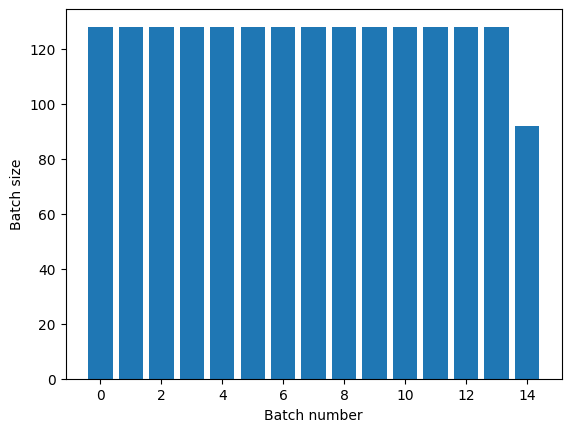

In [69]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

If you need clear epoch separation, put `Dataset.batch` before the repeat:

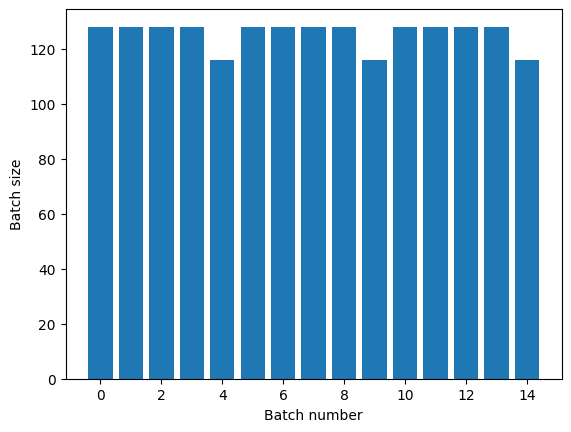

In [70]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

If you would like to perform a custom computation (for example, to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:

In [71]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


### Randomly shuffling input data

The `Dataset.shuffle()` transformation maintains a fixed-size
buffer and chooses the next element uniformly at random from that buffer.

Note: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and significant time to fill. Consider using `Dataset.interleave` across files if this becomes a problem.

Add an index to the dataset so you can see the effect:

In [72]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

Since the `buffer_size` is 100, and the batch size is 20, the first batch contains no elements with an index over 120.

In [73]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 68  52  34  60  30  53 104   9  79  51  36  46  93  19  87  83  22  89
  15  96]


As with `Dataset.batch` the order relative to `Dataset.repeat` matters.

`Dataset.shuffle` doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next:

In [74]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[562 442 616 521 594 394 606 563 505 603]
[576 516 524 311 584 501 509 304 541 561]
[379 609 532 345 626 433 467 525]
[ 93  87  40  24  29   0  26  52 105  37]
[ 65  56  85 109  83  71  28  76 115  95]


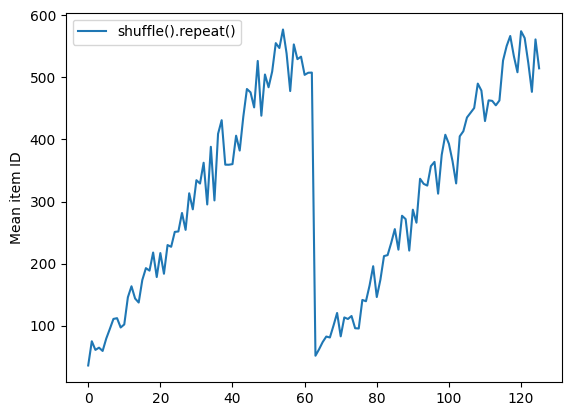

In [75]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

But a repeat before a shuffle mixes the epoch boundaries together:

In [76]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[387 534 390 464 606 584   3 558 498  13]
[  6  28 525 573 554 472  23   1 361   5]
[586  24 451  20   9 620 570  26  12  36]
[481  14   0 535 605  16  35 559  15 391]
[ 44 623 500  52 595  46  18 602  19  17]
[619  38 260  25  69 536  60  77  64 561]
[588 492 499  63  61 599  59 600  41 455]
[580 494 572 564  29 426  47  92 626  10]
[622  50  99 618 615  45 105 582  11 593]
[  7  82 110 340  79 511 103  21 104  43]
[ 34  86  40  65 579 625 578 613  98  89]
[ 31 549 124  42  55  85 132  48 135  56]
[566  32 111 614  76  90 501  37 118 109]
[142 150 143 627 133 136 583  94  53  57]
[141 159 151 164  83  78  70 140   8  68]


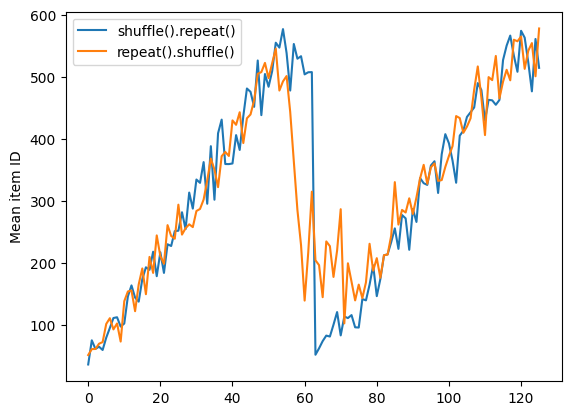

In [77]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## Preprocessing data

The `Dataset.map(f)` transformation produces a new dataset by applying a given
function `f` to each element of the input dataset. It is based on the
[`map()`](https://en.wikipedia.org/wiki/Map_\(higher-order_function\)) function
that is commonly applied to lists (and other structures) in functional
programming languages. The function `f` takes the `tf.Tensor` objects that
represent a single element in the input, and returns the `tf.Tensor` objects
that will represent a single element in the new dataset. Its implementation uses
standard TensorFlow operations to transform one element into another.

This section covers common examples of how to use `Dataset.map()`.


### Decoding image data and resizing it

<!-- TODO(markdaoust): link to image augmentation when it exists -->
When training a neural network on real-world image data, it is often necessary
to convert images of different sizes to a common size, so that they may be
batched into a fixed size.

Rebuild the flower filenames dataset:

In [78]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

Write a function that manipulates the dataset elements.

In [79]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

Test that it works.

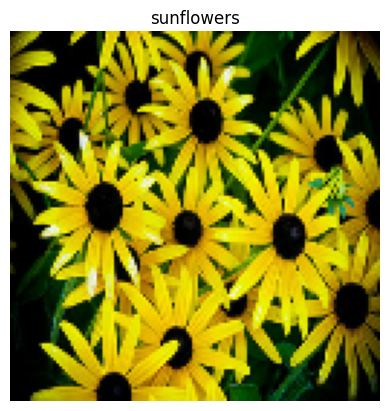

In [80]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

Map it over the dataset.

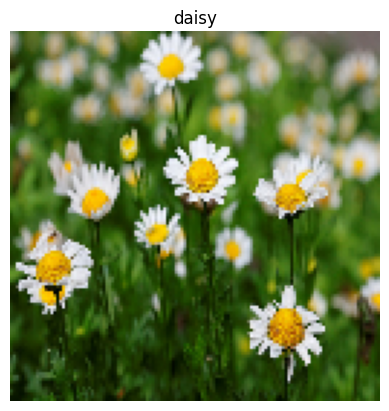

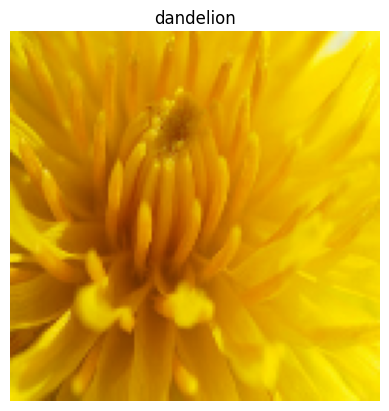

In [81]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

### Applying arbitrary Python logic

For performance reasons, use TensorFlow operations for
preprocessing your data whenever possible. However, it is sometimes useful to
call external Python libraries when parsing your input data. You can use the `tf.py_function` operation in a `Dataset.map` transformation.

For example, if you want to apply a random rotation, the `tf.image` module only has `tf.image.rot90`, which is not very useful for image augmentation.

Note: `tensorflow_addons` has a TensorFlow compatible `rotate` in `tensorflow_addons.image.rotate`.

To demonstrate `tf.py_function`, try using the `scipy.ndimage.rotate` function instead:

In [82]:
import scipy.ndimage as ndimage

@tf.py_function(Tout=tf.float32)
def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

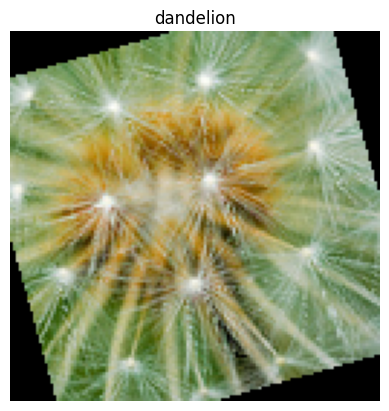

In [83]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

To use this function with `Dataset.map` the same caveats apply as with `Dataset.from_generator`, you need to describe the return shapes and types when you apply the function:

In [84]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  image = random_rotate_image(image)
  image.set_shape(im_shape)
  return image, label

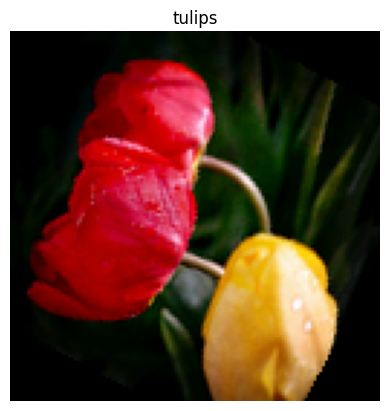

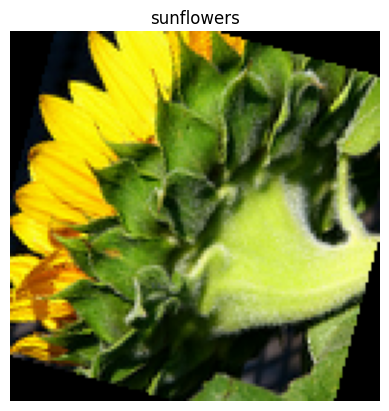

In [85]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

### Parsing `tf.Example` protocol buffer messages

Many input pipelines extract `tf.train.Example` protocol buffer messages from a
TFRecord format. Each `tf.train.Example` record contains one or more "features",
and the input pipeline typically converts these features into tensors.

In [86]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

You can work with `tf.train.Example` protos outside of a `tf.data.Dataset` to understand the data:

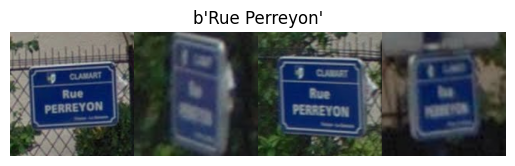

In [87]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [88]:
raw_example = next(iter(dataset))

In [89]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [90]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [91]:
decoded = dataset.map(tf_parse)
decoded

<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [92]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

<a id="time_series_windowing"></a>

### Time series windowing

For an end-to-end time series example see: [Time series forecasting](../../tutorials/structured_data/time_series.ipynb).

Time series data is often organized with the time axis intact.

Use a simple `Dataset.range` to demonstrate:

In [93]:
range_ds = tf.data.Dataset.range(100000)

Typically, models based on this sort of data will want a contiguous time slice.

The simplest approach would be to batch the data:

#### Using `batch`

In [94]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


Or to make dense predictions one step into the future, you might shift the features and labels by one step relative to each other:

In [95]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


To predict a whole window instead of a fixed offset you can split the batches into two parts:

In [96]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Inputs: All except the last 5 steps
          batch[-5:])   # Labels: The last 5 steps

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


To allow some overlap between the features of one batch and the labels of another, use `Dataset.zip`:

In [97]:
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52]


#### Using `window`

While using `Dataset.batch` works, there are situations where you may need finer control. The `Dataset.window` method gives you complete control, but requires some care: it returns a `Dataset` of `Datasets`. Go to the [Dataset structure](#dataset_structure) section for details.

In [98]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


The `Dataset.flat_map` method can take a dataset of datasets and flatten it into a single dataset:

In [99]:
 for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

In nearly all cases, you will want to `Dataset.batch` the dataset first:

In [100]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


Now, you can see that the `shift` argument controls how much each window moves over.

Putting this together you might write this function:

In [101]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows


In [102]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


Then it's easy to extract labels, as before:

In [103]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


### Resampling

When working with a dataset that is very class-imbalanced, you may want to resample the dataset. `tf.data` provides two methods to do this. The credit card fraud dataset is a good example of this sort of problem.

Note: Go to [Classification on imbalanced data](../tutorials/structured_data/imbalanced_data.ipynb) for a full tutorial.


In [104]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

69155632/69155632 [==============================] - 1s 0us/step


In [105]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

Now, check the distribution of classes, it is highly skewed:

In [106]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [107]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.996 0.004]


A common approach to training with an imbalanced dataset is to balance it. `tf.data` includes a few methods which enable this workflow:

#### Datasets sampling

One approach to resampling a dataset is to use `sample_from_datasets`. This is more applicable when you have a separate `tf.data.Dataset` for each class.

Here, just use filter to generate them from the credit card fraud data:

In [108]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

In [109]:
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


To use `tf.data.Dataset.sample_from_datasets` pass the datasets, and the weight for each:

In [110]:
balanced_ds = tf.data.Dataset.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

Now the dataset produces examples of each class with a 50/50 probability:

In [111]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 0 1 0 0 0 1 0 1 1]
[1 0 1 0 1 1 1 1 0 0]
[0 1 0 1 1 0 0 0 1 1]
[0 1 1 0 0 0 0 1 1 1]
[0 0 0 1 1 0 0 0 1 1]
[1 1 1 1 1 1 1 0 1 0]
[0 0 1 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1]
[0 0 1 1 1 1 1 1 1 0]
[0 1 0 1 1 1 0 0 0 0]


#### Rejection resampling

One problem with the above `Dataset.sample_from_datasets` approach is that
it needs a separate `tf.data.Dataset` per class. You could use `Dataset.filter`
to create those two datasets, but that results in all the data being loaded twice.

The `tf.data.Dataset.rejection_resample` method can be applied to a dataset to rebalance it, while only loading it once. Elements will be dropped or repeated to achieve balance.

The `rejection_resample` method takes a `class_func` argument. This `class_func` is applied to each dataset element, and is used to determine which class an example belongs to for the purposes of balancing.

The goal here is to balance the label distribution, and the elements of `creditcard_ds` are already `(features, label)` pairs. So the `class_func` just needs to return those labels:

In [112]:
def class_func(features, label):
  return label

The resampling method deals with individual examples, so in this case you must `unbatch` the dataset before applying that method.

The method needs a target distribution, and optionally an initial distribution estimate as inputs.

In [113]:
resample_ds = (
    creditcard_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.5,0.5],
                        initial_dist=fractions)
    .batch(10))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



The `rejection_resample` method returns `(class, example)` pairs where the `class` is the output of the `class_func`. In this case, the `example` was already a `(feature, label)` pair, so use `map` to drop the extra copy of the labels:

In [114]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

Now the dataset produces examples of each class with a 50/50 probability:

In [115]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 0 1 1 1 0 0 1 1 0]
[1 0 1 1 0 0 1 1 1 1]
[0 1 0 1 0 0 0 1 1 0]
[1 0 1 1 1 1 0 0 0 1]
[1 0 1 1 0 0 1 1 1 0]
[1 1 0 1 1 1 1 0 0 1]
[0 1 0 1 1 1 1 1 0 0]
[1 1 1 0 1 1 1 0 1 1]
[0 0 0 1 1 0 0 0 0 0]
[1 0 1 1 0 0 0 1 0 0]


## Iterator Checkpointing

Tensorflow supports [taking checkpoints](./checkpoint.ipynb) so that when your training process restarts it can restore the latest checkpoint to recover most of its progress. In addition to checkpointing the model variables, you can also checkpoint the progress of the dataset iterator. This could be useful if you have a large dataset and don't want to start the dataset from the beginning on each restart. Note however that iterator checkpoints may be large, since transformations such as `Dataset.shuffle` and `Dataset.prefetch` require buffering elements within the iterator.

To include your iterator in a checkpoint, pass the iterator to the `tf.train.Checkpoint` constructor.

In [116]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]


Note: It is not possible to checkpoint an iterator which relies on an external state, such as a `tf.py_function`. Attempting to do so will raise an exception complaining about the external state.

## Using `tf.data` with `tf.keras`

The `tf.keras` API simplifies many aspects of creating and executing machine
learning models. Its `Model.fit` and `Model.evaluate` and `Model.predict` APIs support datasets as inputs. Here is a quick dataset and model setup:

In [117]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [118]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

 Passing a dataset of `(feature, label)` pairs is all that's needed for `Model.fit` and `Model.evaluate`:

In [119]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6004 - accuracy: 0.7983
Epoch 2/2
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4626 - accuracy: 0.8422


If you pass an infinite dataset, for example by calling `Dataset.repeat`, you just need to also pass the `steps_per_epoch` argument:

In [120]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy: 0.8328
Epoch 2/2
20/20 [==============================] - 0s 2ms/step - loss: 0.3752 - accuracy: 0.8703


For evaluation you can pass the number of evaluation steps:

In [121]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 3s 1ms/step - loss: 0.4356 - accuracy: 0.8509
Loss : 0.4356495440006256
Accuracy : 0.8508833050727844


For long datasets, set the number of steps to evaluate:

In [122]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.4283 - accuracy: 0.8781
Loss : 0.4283166825771332
Accuracy : 0.878125011920929


The labels are not required when calling `Model.predict`.

In [123]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

10/10 [==============================] - 0s 3ms/step
(320, 10)


But the labels are ignored if you do pass a dataset containing them:

In [124]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

10/10 [==============================] - 0s 2ms/step
(320, 10)
